# **SKIN DISEASE CLASSIFICATION**

Deep learning to predict the various skin diseases. The main objective of this project is to achieve maximum accuracy of skin disease prediction.
Deep learning techniques helps in detection of skin disease at an initial stage. The feature extraction plays a key role in classification of skin diseases.The usage of Deep Learning algorithms reduces the need for human labor, such as manual feature extraction and data reconstruction for classification purpose.
Moreover, Explainable AI is used to interpret the decisions made by our model.

## ABOUT THE DATASET

HAM10000 ("Human Against Machine with 10000 training images") dataset - a large collection of multi-source dermatoscopic images of pigmented lesions

The dermatoscopic images are collected from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images.

It has 7 different classes of skin cancer which are listed below :
- Melanocytic nevi
- Melanoma
- Benign keratosis-like lesions
- Basal cell carcinoma
- Actinic keratoses
- Vascular lesions
- Dermatofibroma


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap  # Use this instead
from scipy.special import logit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Then use shap.KernelExplainer instead of KernelShap

In [2]:
#Importing required libraries
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

In [3]:
# Reading the data from HAM_metadata.csv
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [4]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [6]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


## **Data Cleaning**

### Removing NULL values and performing visualizations to gain insights of dataset: Univariate and Bivariate Analysis

In [7]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

The feature 'age' consists of 57 null records. Thus, we need to replace them with the mean of 'age' since dropping 57 records would lead to loss of data.

In [8]:
df['age'].fillna(int(df['age'].mean()),inplace=True)

In [9]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [10]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '../input/skin-cancer-mnist-ham10000'

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [11]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


## **Image Preprocessing**

### Resizing of images because the original dimensions of 450 * 600 * 3 take long time to process in Neural Networks

In [12]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

Showcasing some samples of each class of the dataset in the images below:

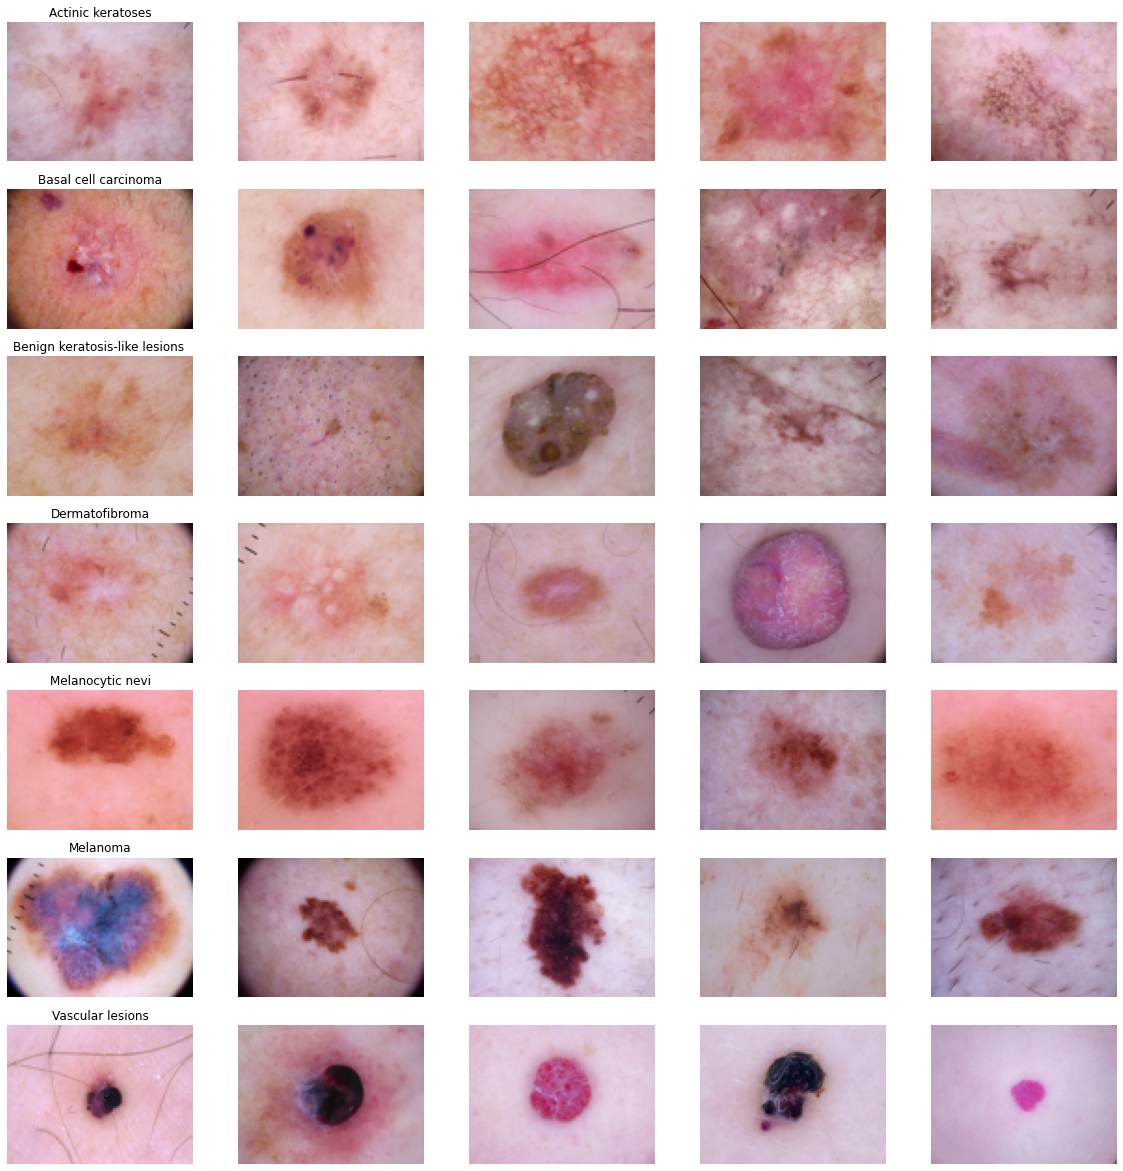

In [13]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [14]:
# See the image size distribution - should just return one row (all images are uniform)
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

## **Exploratory Data Analysis**

Exploratory data analysis can help detect obvious errors, identify outliers in datasets, understand relationships, unearth important factors, find patterns within data, and provide new insights.

In [15]:
df= df[df['age'] != 0]
df= df[df['sex'] != 'unknown']

### UNIVARIATE ANALYSIS

<AxesSubplot:title={'center':'CELL TYPE'}, ylabel='Count'>

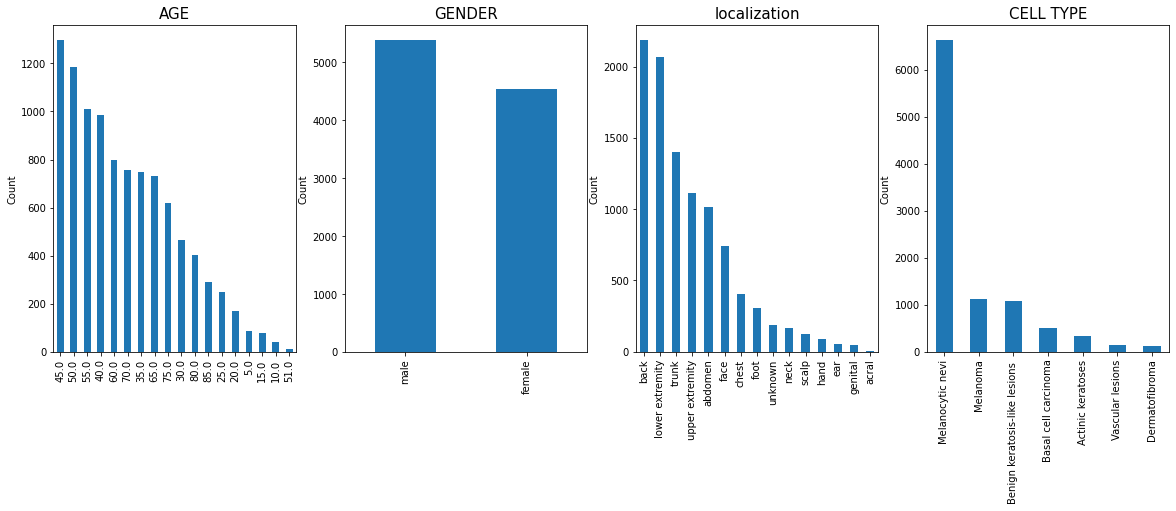

In [16]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
df['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
df['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
df['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
df['cell_type'].value_counts().plot.bar()

1. Skin diseases are found to be maximum in people aged around 45. Minimum for 10 and below. We also observe that the probability of having skin disease increases with the increase in age.
2. Skin diseases are more prominent in Men as compared to Women and other gender.
3. Skin diseases are more visible on the "back" of the body and least on the "acral surfaces"(such as limbs, fingers, or ears).
4. The most found disease among people is Melanocytic nevi while the least found is Dermatofibroma.

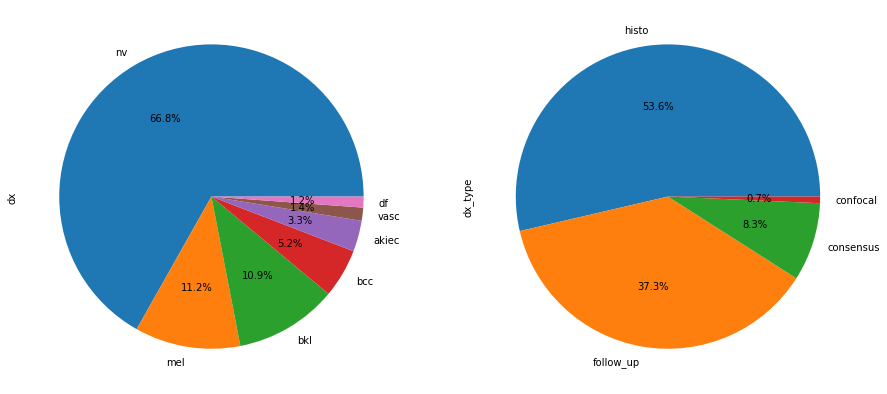

In [17]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
df['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
df['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

1.  Type of skin disease:
    *     nv: Melanocytic nevi - 69.9%
    *     mel: Melanoma - 11.1 %
    *     bkl: Benign keratosis-like lesions - 11.0%
    *     bcc: Basal cell carcinoma - 5.1%
    *     akiec: Actinic keratoses- 3.3%
    *     vasc: Vascular lesions-1.4%
    *     df: Dermatofibroma - 1.1%

2. How the skin disease was discovered:
   * histo - histopathology - 53.3%
   * follow_up - follow up examination - 37.0%
   * consensus - expert consensus - 9.0%
   * confocal - confirmation by in-vivo confocal microscopy - 0.7%

### BIVARIATE ANALYSIS

<AxesSubplot:title={'center':'LOCALIZATION VS GENDER'}, xlabel='count', ylabel='localization'>

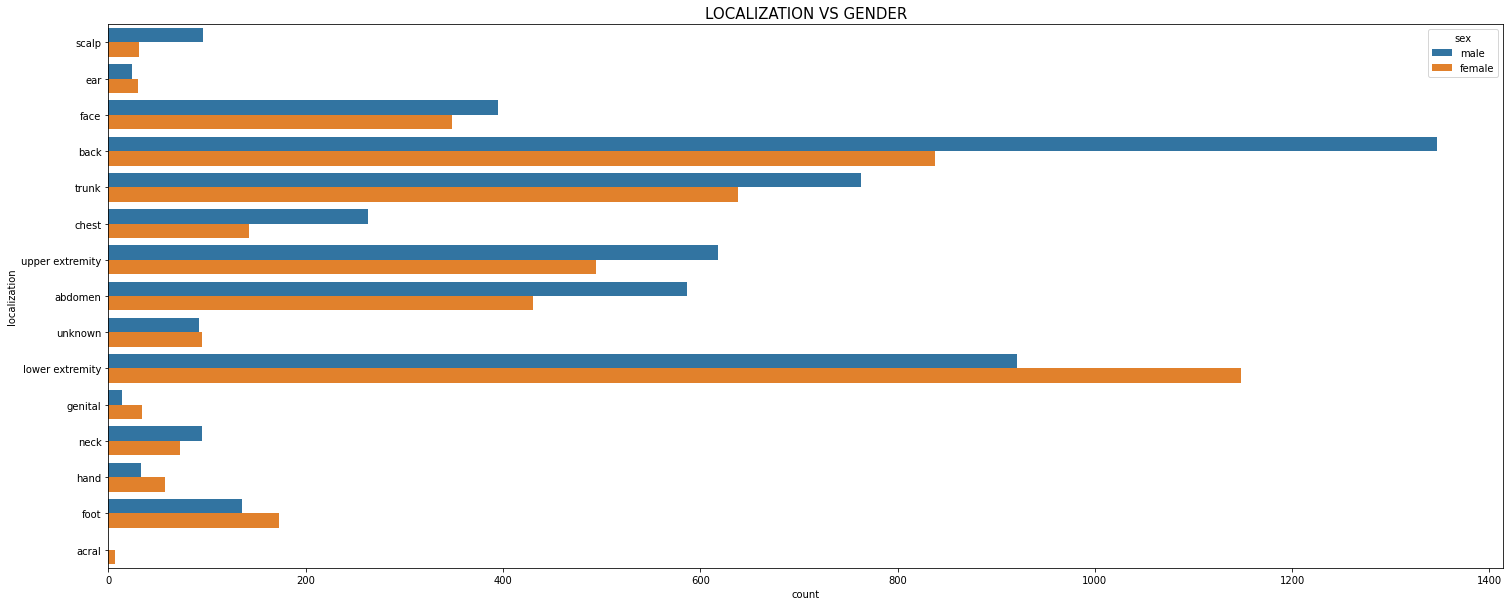

In [18]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS GENDER',fontsize = 15)
sns.countplot(y='localization', hue='sex',data=df)

* Back are is the most affected among people and more prominent in men.
* Infection on Lower extremity of the body is more visible in women.
* Some unknown regions also show infections and it's visible in men, women and other genders.
* The acral surfaces show the least infection cases that too in men only. Other gender groups don't show this kind of infection.


<AxesSubplot:title={'center':'GENDER VS CELL TYPE'}, xlabel='count', ylabel='sex'>

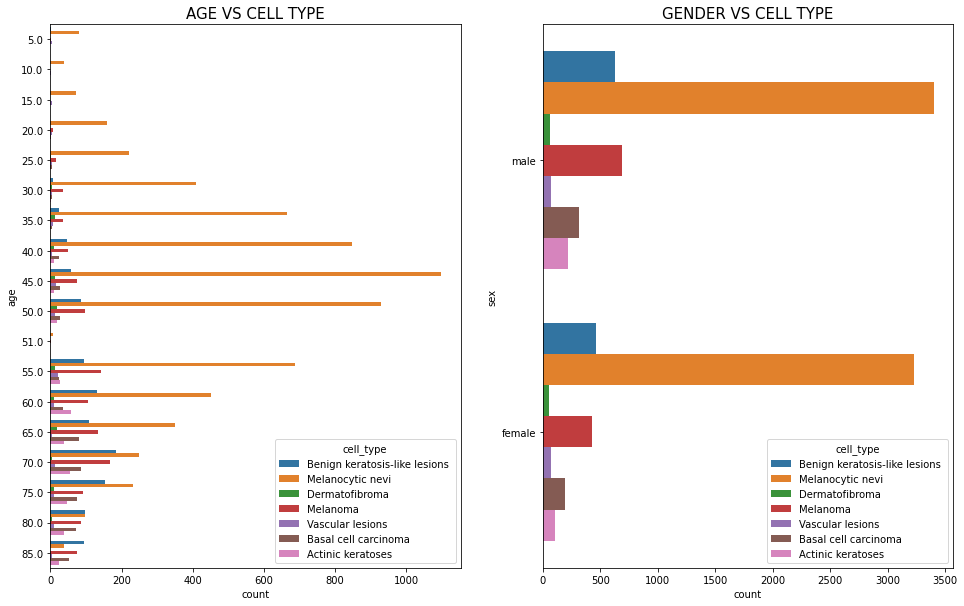

In [19]:
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.title('AGE VS CELL TYPE',fontsize = 15)
sns.countplot(y='age', hue='cell_type',data=df)
plt.subplot(132)
plt.title('GENDER VS CELL TYPE',fontsize = 15)
sns.countplot(y='sex', hue='cell_type',data=df)

1. The age group between 0-75 years is infected the most by Melanocytic nevi. On the other hand, the people aged 80-90 are affected more by Benign keratosis-like lesions.

2. All the gender groups are affected the most by Melanocytic nevi.

## **CNN**

CNN is ideal for image classification. It is better since CNN has features parameter sharing and dimensionality reduction. Because of parameter sharing in CNN, the number of parameters is reduced thus the computations get decreased.


### Applied Data augmentation using ImageDatagenerator before model training

Since the data is less, we apply data augmentation using ImageDataGenerator.

ImageDataGenerator generates augmentation of images in real-time while the model is still training. One can apply any random transformations on each training image as it is passed to the model.

#### The CNN model is a repeated network of the following layers:

1. Convolutional
1. Pooling
1. Dropout
1. Flatten
1. Dense

Optimizer: Adam

Activation function used: Softmax



In [20]:
from keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*3 -> Flatten -> Dense*2 -> Dropout -> Out
input_shape = (100, 75, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 75, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 75, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 37, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 18, 32)        0

In [22]:
# Define the optimizer
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [23]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [24]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [25]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [26]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanocytic nevi', b'Basal cell carcinoma', b'Melanoma',
       b'Actinic keratoses', b'Vascular lesions',
       b'Benign keratosis-like lesions ', b'Dermatofibroma'], dtype=object)>, idx=<tf.Tensor: shape=(7440,), dtype=int32, numpy=array([0, 1, 2, ..., 1, 0, 0], dtype=int32)>)

In [27]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [28]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [29]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 75, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 75, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 75, 3))
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [30]:
# Fit the model
epochs = 50
batch_size = 16
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

from tensorflow.keras.metrics import Recall
from sklearn.metrics import classification_report,confusion_matrix

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
418/418 [==============================] - 20s 29ms/step - loss: 1.1423 - accuracy: 0.6525 - val_loss: 1.0132 - val_accuracy: 0.6626
Epoch 2/50
418/418 [==============================] - 12s 28ms/step - loss: 1.0053 - accuracy: 0.6534 - val_loss: 0.9408 - val_accuracy: 0.6694
Epoch 3/50
418/418 [==============================] - 12s 28ms/step - loss: 0.9331 - accuracy: 0.6597 - val_loss: 0.9324 - val_accuracy: 0.6599
Epoch 4/50
418/418 [==============================] - 12s 28ms/step - loss: 0.9008 - accuracy: 0.6713 - val_loss: 0.8944 - val_accuracy: 0.6586
Epoch 5/50
418/418 [==============================] - 12s 28ms/step - loss: 0.8743 - accuracy: 0.6786 - val_loss: 0.8859 - val_accuracy: 0.6962
Epoch 6/50
418/418 [==============================] - 12s 28ms/step - loss: 0.8492 - accuracy: 0.6889 - val_loss: 0.9078 - val_accuracy: 0.6909
Epoch 7/50
418/418 [==============================] - 12s 27ms/step - loss: 0.8426 - accuracy: 0.6898 - val_loss: 0.8736 - val_accuracy:

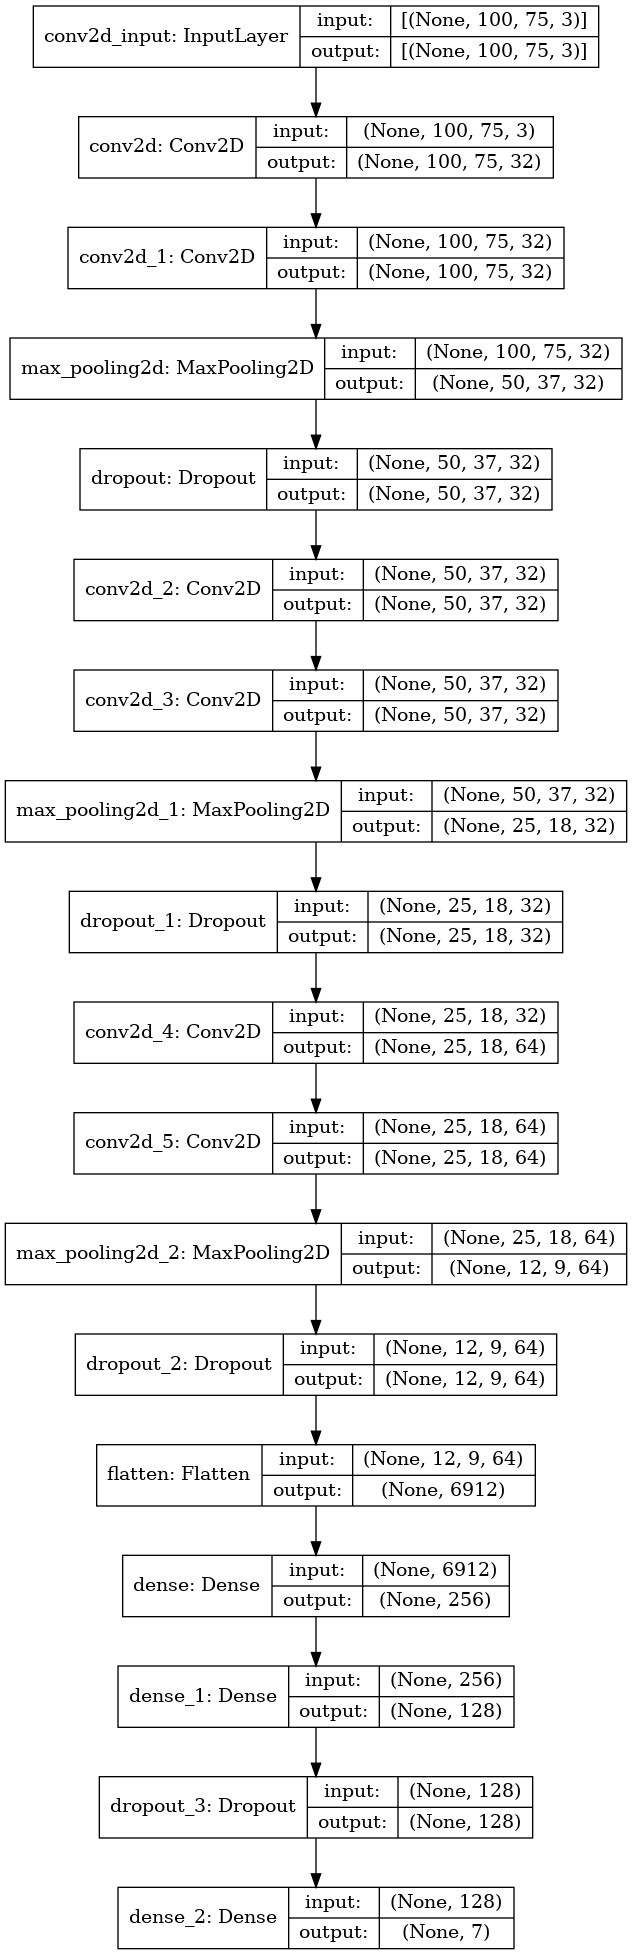

In [31]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

The CNN model has been visualised in the model attached above.

In [32]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

24/24 [==============================] - 0s 4ms/step - loss: 0.7449 - accuracy: 0.7003
Validation: accuracy = 0.700269  ;  loss_v = 0.744946
Test: accuracy = 0.717453  ;  loss = 0.733251


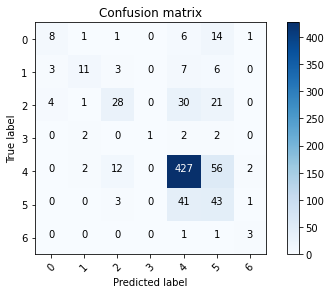

In [33]:
import itertools
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 


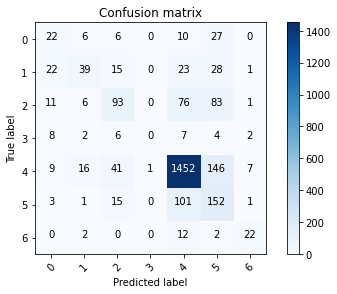

In [34]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

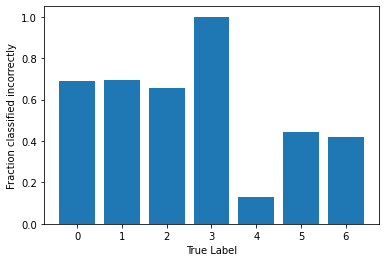

In [35]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [36]:
model.save("model.h5")

## **XAI**

### Interpretation of results of model using Feature Importance techniques

The increasing trend in the use of machine learning for critical applications such as medical diagnosis suggests an imperative need for methodologies that can help to understand and evaluate the predictions of machine-learning models. 

There are two main ways to look at a classification or a regression model: 
1. inspect model parameters and try to figure out how the model works globally; 
2. inspect an individual prediction of a model, try to figure out why the model makes the decision it makes. 

For example, LIME, or Local Interpretable Model-Agnostic Explanations, is an algorithm that can explain the predictions of any classifier or regressor in a faithful way, by approximating it locally with an interpretable model.-


### Techniques applied: LIME, PDP, SHAP, etc.

In [37]:
tile_df = df.copy()

In [38]:
tile_df.drop('lesion_id', inplace=True, axis=1)
tile_df.drop('image_id', inplace=True, axis=1)
tile_df.drop('cell_type', inplace=True, axis=1)
tile_df.drop('path', inplace=True, axis=1)
tile_df.drop('dx', inplace=True, axis=1)
tile_df.head()

,dx_type,age,sex,localization,cell_type_idx,image
0,histo,80.0,male,scalp,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,histo,80.0,male,scalp,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,histo,80.0,male,scalp,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,histo,80.0,male,scalp,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,histo,75.0,male,ear,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


In [39]:
X = tile_df.drop(['cell_type_idx'],axis=1).values
y = tile_df['cell_type_idx'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [41]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import logit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


As the dataframe consisted of a few features in the form of strings, we have processed these features by localization one hot method. 

In [42]:
tile_df['localization_onehot'] = tile_df.localization.map({'scalp':0, 'ear':1, 'face':2, 'neck':3,'back':4, 'trunk':5, 'chest':6,
       'upper extremity':7, 'abdomen':8, 'lower extremity':9,
       'genital':10, 'hand':11, 'foot':12, 'acral':13, 'unknown':14})
tile_df.head()

,dx_type,age,sex,localization,cell_type_idx,image,localization_onehot
0,histo,80.0,male,scalp,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,...",0
1,histo,80.0,male,scalp,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3...",0
2,histo,80.0,male,scalp,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,...",0
3,histo,80.0,male,scalp,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5...",0
4,histo,75.0,male,ear,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ...",1


In [43]:
tile_df['dx_type_onehot'] = tile_df.dx_type.map({'confocal':0,'consensus':1,'follow_up':2,'histo':3})
tile_df.head()

,dx_type,age,sex,localization,cell_type_idx,image,localization_onehot,dx_type_onehot
0,histo,80.0,male,scalp,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,...",0,3
1,histo,80.0,male,scalp,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3...",0,3
2,histo,80.0,male,scalp,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,...",0,3
3,histo,80.0,male,scalp,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5...",0,3
4,histo,75.0,male,ear,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ...",1,3


In [44]:
tile_df['gender_male'] = tile_df.sex.map({'female':0, 'male':1, 'unknown':2})
tile_df.head()

,dx_type,age,sex,localization,cell_type_idx,image,localization_onehot,dx_type_onehot,gender_male
0,histo,80.0,male,scalp,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,...",0,3,1
1,histo,80.0,male,scalp,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3...",0,3,1
2,histo,80.0,male,scalp,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,...",0,3,1
3,histo,80.0,male,scalp,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5...",0,3,1
4,histo,75.0,male,ear,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ...",1,3,1


In [45]:
tile_df.columns

Index(['dx_type', 'age', 'sex', 'localization', 'cell_type_idx', 'image',
       'localization_onehot', 'dx_type_onehot', 'gender_male'],
      dtype='object')

In [46]:
features = ['age',  'localization_onehot', 'dx_type_onehot','gender_male']

In [47]:
X = tile_df[features]
y = tile_df['cell_type_idx'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [48]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

Creating a XGB Classifier model for the prediction of the type of skin disease using a tabular dataset:

In [49]:
xgb_model = XGBClassifier(random_state=1)
xgb_model = xgb_model.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:01:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [50]:
y_pred = xgb_model.predict(X_test)

In [51]:
predictions = [round(value) for value in y_pred]

In [52]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.87%


**Shap:**

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional theory.

![](https://christophm.github.io/interpretable-ml-book/images/shap-simplified-features.jpg)

In [53]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [54]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  [-0.6565658, -0.22117907, 0.45192364, -1.8466053, 2.6667223, 0.53093946, -1.2809393]


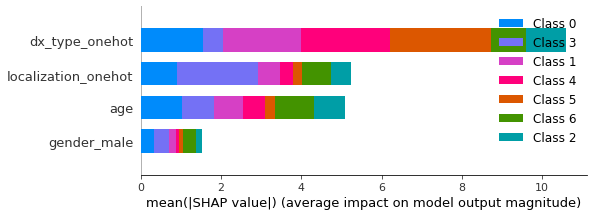

In [55]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

The feature importance plot, other than showing us which features are the most important, also show us which feature plays a major role in the prediction of which class.
For example, we observe that the localization plays a major role in predicting whether the disease belongs to class 3. Similarly, dx_type_onehot plays a major role in predicting whether the disease belongs to class 1, 5, etc.

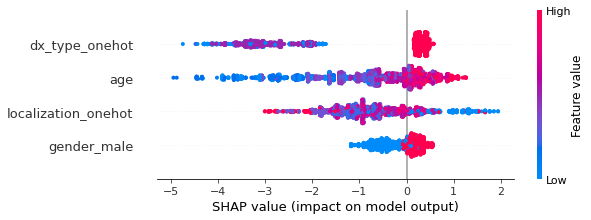

In [56]:
shap.summary_plot(shap_values[0], X_test)

From this summary plot, we observe the effect of the different values of each feature on the SHAP value, which is used for prediction. For example, we see that the higher values of dx_type_onehot (follow up and histopathology) are associated with a higher SHAP value.

In [57]:
from sklearn.preprocessing import LabelEncoder

## Preprocess training and test target (y) after having performed train-test split
le = LabelEncoder()
y_multi_train = pd.Series(le.fit_transform(y_train))
y_multi_test = pd.Series(le.transform(y_test))

## Check classes
le.classes_

array([0, 1, 2, 3, 4, 5, 6], dtype=int8)

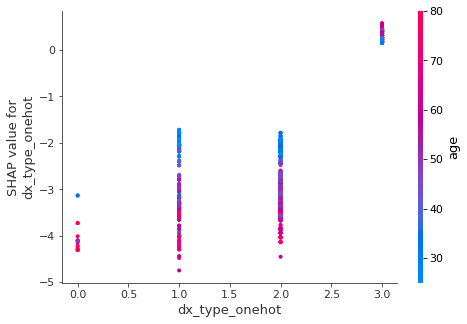

In [58]:
shap.initjs()
shap.dependence_plot('dx_type_onehot', interaction_index='age',
                     shap_values=shap_values[0], 
                     features=X_test,  
                     display_features=X_test)

In this graph, the effect of dx_type_onehot at specific ages is seen on the SHAP value. In congruence to what we observed in the earlier graph, the higher the value for dx_type_onehot (expert consensus or confirmation by microscopy) 

In [59]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][:100,:], X_test.iloc[:100,:])

In [60]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][15,:], X_test.iloc[15,:])

Here, the force plot shows a local instance of the dataset. The localisation and type of diagnosis impact the prediction positively due to their positive SHAP value. 
On the other hand, the age and gender of the patient impacts the model negatively. 

**PDP :**

The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. 

A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex.

For each of the categories, we get a PDP estimate by forcing all data instances to have the same category. 


In [63]:
from pdpbox import pdp, get_dataset, info_plots

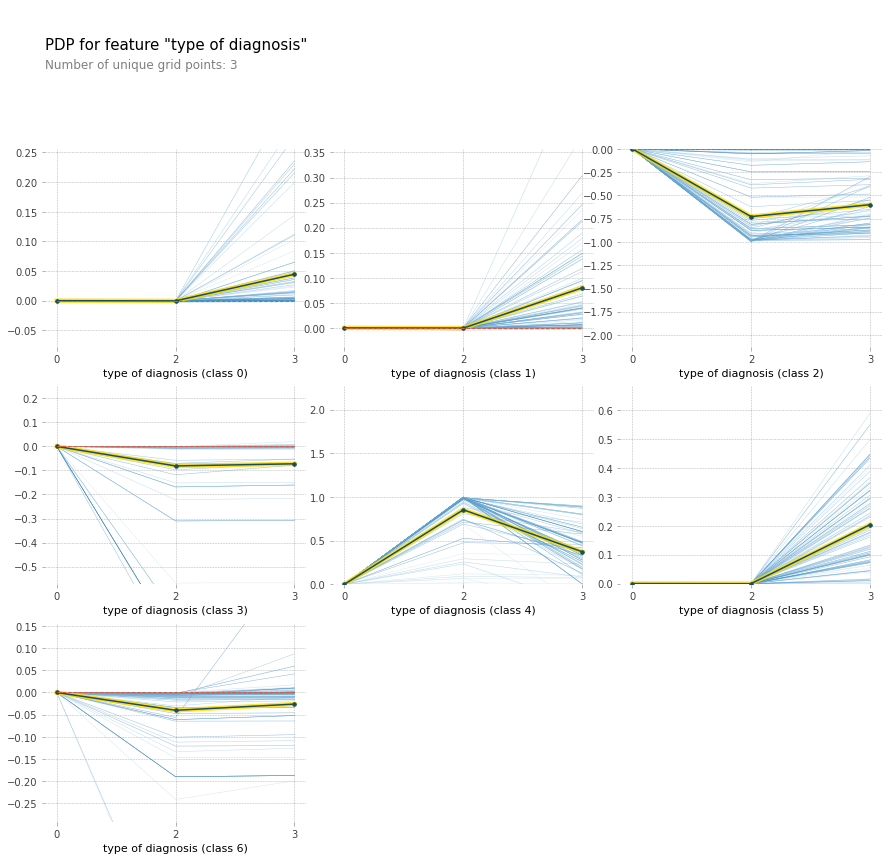

In [77]:
pdp_feat_67_rf = pdp.pdp_isolate(model=xgb_model,
                                 dataset=X_train,
                                 model_features=features,
                                 feature='dx_type_onehot')
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_feat_67_rf,
                         feature_name='type of diagnosis',
                         center=True,
                         x_quantile=True,
                         ncols=3,
                         plot_lines=True,
                         frac_to_plot=100)

The PDP (Partial Dependence Plot) shows us the relation between an increase/decrease of one feature to the prediction of the model. 

For example:
In figure 1 (class 0), we observe that the chances of the skin disease belonging to class 0 increases when the value of dx_type_onehot changes from 2 (follow up) to 3 (histopathology).

Similarly, in figure 5 (class 4), we observe that the probability of the skin disease belonging to class 4 is extremely high when the value of dx_type_onehot lies between 0 and 2, and decreases comparatively when it lies between 2 and 3.

Similarly, probability of the skin disease belonging to class 6 is extremely low when the value of dx_type_onehot lies between 0 and 2 (confocal, consensus and follow up), and increases comparatively when it changes from 2 to 3.

## **LIME**

### LIME is a technique that explains how the input features of a machine learning model affect its predictions. For instance, for image classification tasks, LIME finds the region of an image (set of super-pixels) with the strongest association with a prediction label.


### LIME creates explanations by generating a new dataset of random perturbations (with their respective predictions) around the instance being explained and then fitting a weighted local surrogate model -  model that gives explanation of individual predictions.

Step 1: Generate random perturbations for input image

Step 2: Predict class for perturbations

Step 3: Compute weights (importance) for the perturbations

Step 4: Fit a explainable linear model using the perturbations, predictions and weights


In [65]:
import skimage.io 
import skimage.segmentation

In [66]:
np.random.seed(222)

Xi = x_test[3]
preds = model.predict(Xi[np.newaxis,:,:,:])
top_pred_classes = preds[0].argsort()[-5:][::-1] # Save ids of top 5 classes
top_pred_classes

array([5, 2, 4, 0, 1])

In [67]:
print(y_test[3])

4


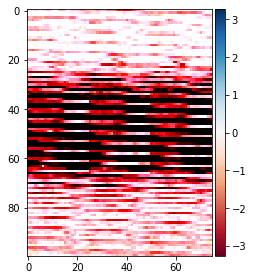

In [68]:
skimage.io.imshow(Xi)

The number of super pixels generated


9

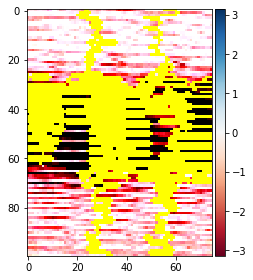

In [69]:
#Generate segmentation for image
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi, superpixels))
print("The number of super pixels generated")
num_superpixels

In [70]:
#Generate perturbations
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

#Create function to apply perturbations to images
import copy
def perturb_image(img,perturbation,segments): 
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

#Show example of perturbations
print(perturbations[0]) 

[1 1 1 1 0 0 1 0 1]


In [71]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
print(predictions.shape)

(150, 1, 7)


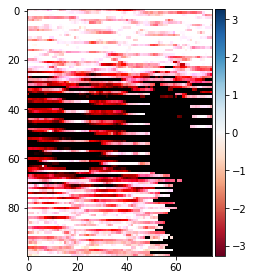

In [72]:
skimage.io.imshow(perturb_image(Xi,perturbations[0],superpixels))

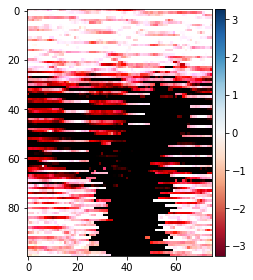

In [73]:
skimage.io.imshow(perturb_image(Xi,perturbations[11],superpixels))

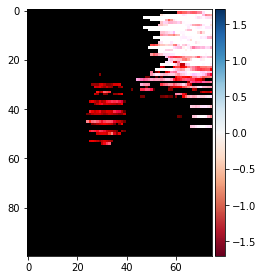

In [74]:
skimage.io.imshow(perturb_image(Xi,perturbations[2],superpixels))

In [75]:
#Compute distances to original image
import sklearn.metrics
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
print(distances.shape)

#Transform distances to a value between 0 an 1 (weights) using a kernel function
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
print(weights.shape)

(150,)
(150,)


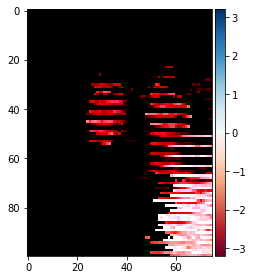

In [76]:
#Estimate linear model
from sklearn.linear_model import LinearRegression
class_to_explain = 4
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]

#Use coefficients from linear model to extract top features
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 

#Show only the superpixels corresponding to the top features
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi,mask,superpixels))

This is what LIME returns as explanation. 
The area of the image (super-pixels) that has a stronger association with the prediction of the disease of class 4. This explanation suggests that the model is doing a good job predicting the class for the given image. 

This example shows how LIME can help to increase confidence in a machine-learning model by understanding why it is returning certain predictions.